In [8]:
# !git clone https://www.github.com/yankeesong/MLE.git
# !pip install d2l==1.0.0b0
%matplotlib inline
#from google.colab import files
import sys, torchvision, os
import collections
import random
sys.path.insert(0,'/content/MLE')
from dl_helpers_Yanke import *

## PTB dataset

In [16]:
# PTB dataset
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')


def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

vocab = d2l.Vocab(sentences, min_freq=10)

# Sub-sampling large frequency words
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)
    
subsampled, counter = subsample(sentences, vocab)
corpus = [vocab[line] for line in subsampled]

# Get center and context words
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

all_centers, all_contexts = get_centers_and_contexts(corpus, 5)

# Negative Sampling
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

# Make batches
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))
    
# Putting them together
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

## Pretraining word2vec using skip-gram

loss 0.410, 219459.9 tokens/sec on cuda:0


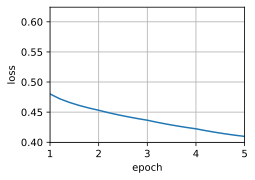

In [17]:
# Load data
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

# Define skip-gram
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

# Loss function
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

# Initialization
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

# Start training
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [20]:
# Test word embedding
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.706: microprocessor
cosine sim=0.672: intel
cosine sim=0.639: bugs


## Load pre-trained embeddings

In [22]:
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

# Download
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [31]:
# Similarity
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')
        
get_similar_tokens('boyfriend', 3, glove_6b50d)

cosine sim=0.942: girlfriend
cosine sim=0.902: fiance
cosine sim=0.843: fiancee


In [32]:
# Analogy
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])] 
get_analogy('man', 'woman', 'husband', glove_6b50d)

## BERT

In [44]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

# Masks prediction
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

# Next sentence prediction
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

# Putting together
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [45]:
# Wikitext2 dataset
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)
    
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


MLM loss 5.677, NSP loss 0.794
6084.8 sentence pairs/sec on [device(type='cuda', index=0)]


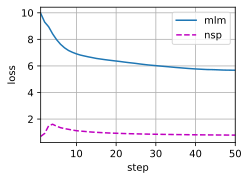

In [46]:
# Training
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')
    
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [49]:
# Test trained encodings
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X